<h1> Second Round of BERT Training </h1>

In this round, I follow the RoBERTa implementation, which uses dynamic masking and whole-text prediction (rather than NSP). Named entity tokens in the dataset have now been replaced with their BIOES tags. I also add regularization in attempt to balance the distribution of samples across targets in the corpus.


In [87]:
#use pyto_env kernel, pyto env.

import os
import re
import json
import pandas as pd
import stanza
import spacy 
import importlib
import pickle
import numpy as np

import torch
from torch.optim import Adagrad, AdamW
from transformers import BertTokenizer, BertForSequenceClassification, PretrainedConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics import F1Score

from transformers import (Trainer, 
                          RobertaTokenizer, 
                          RobertaModel, 
                          RobertaForSequenceClassification, 
                          RobertaConfig, 
                          RobertaForMaskedLM)

from transformers import get_linear_schedule_with_warmup, default_data_collator

import common
from common import (ClassificationDataset, 
                    BERT_fine_tune_validation, 
                    BERT_fine_tune_train, 
                    plot_confusion_matrix, 
                    train_test_val_split)

In [2]:
project_dir = "/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis"
data_dir = os.path.join(project_dir,"Data")
model_dir = os.path.join(project_dir, "Models")
roberta_dir = os.path.join(model_dir, 'robert-classifier')

os.chdir(data_dir)

masked_dataset = pd.read_csv('masked_data_set.csv', index_col = 0)

#L1 to integer map for loading categories into BERT
with open('target_idx.json') as f:
    data = f.read()
target_idx = json.loads(data)
idx_target = {target_idx[a]:a for a in target_idx.keys()}

n_classes = len(target_idx.keys())

# additional special tokens
with open('spec_tokens_ne.txt', 'rb') as file:
    spec_tokens = pickle.load(file)
    
# Load from data directory
masked_dataset = pd.read_csv('masked_data_set.csv', index_col=0)

In [3]:
from focal_loss.focal_loss import FocalLoss

<h1> RoBERTa </h1>

<h2> Create Pre-training Dataset </h2>

In [4]:
from torch.utils.data import RandomSampler

def remove_blanklines(text):
    no_newline = re.sub('\n\n', '\n\t', text)
    return no_newline

new_dataset = masked_dataset
new_dataset['Text'] = masked_dataset['Text'].apply(lambda x : remove_blanklines(x))

In [5]:

def sample_dataset(df, sampler, n):
    ds = ''
    for a in range(n):
        text = df['Text'].iloc[next(sampler)]
        ds = ds + '\n\n\n\n' + text
    return ds

def tr_ts_vl_split(df, tr_size=0.85, vl_size=0.075):
    
    sampler = RandomSampler(df)
    iterator = iter(sampler)
    
    n_samples = len(sampler)
    ts_size = 1.0-tr_size-vl_size
    
    train_size = round(tr_size*n_samples)
    val_size = round(vl_size*n_samples)
    test_size = n_samples - train_size - val_size
    
    train_ds = sample_dataset(df, iterator, train_size)
    val_ds = sample_dataset(df, iterator, val_size)
    test_ds = sample_dataset(df, iterator, test_size)
    
    return train_ds, val_ds, test_ds
    

In [6]:
train_ds, val_ds, test_ds = tr_ts_vl_split(new_dataset)

In [7]:
with open('roberta_pretrain_train_ds.txt', 'w') as file:
    file.write(train_ds)
with open('roberta_pretrain_val_ds.txt', 'w') as file:
    file.write(val_ds)
with open('roberta_pretain_test_ds.txt', 'w') as file:
    file.write(test_ds)

In [8]:
os.chdir(data_dir)

In [9]:
import fairseq

In [10]:
from fairseq.examples.roberta import multiprocessing_bpe_encoder

In [11]:
help(fairseq)

Help on package fairseq:

NAME
    fairseq - isort:skip_file

PACKAGE CONTENTS
    benchmark (package)
    binarizer
    checkpoint_utils
    config (package)
    criterions (package)
    data (package)
    dataclass (package)
    distributed (package)
    examples (package)
    file_chunker_utils
    file_io
    file_utils
    hub_utils
    incremental_decoding_utils
    iterative_refinement_generator
    libbleu
    logging (package)
    model_parallel (package)
    models (package)
    modules (package)
    nan_detector
    ngram_repeat_block
    optim (package)
    options
    pdb
    quantization_utils
    registry
    scoring (package)
    search
    sequence_generator
    sequence_scorer
    speech_generator
    tasks (package)
    token_generation_constraints
    tokenizer
    trainer
    utils
    version

SUBMODULES
    distributed_utils
    meters
    metrics
    progress_bar

DATA
    __all__ = ['pdb']

VERSION
    0.12.2

FILE
    /Users/paulp/miniforge3/envs/pyto/lib/pyth

The following is adapted from the fairseq.examples.roberta, and runs from the shell but not with Jupyter:

#cd ../Data
#mkdir -p gpt2_bpe

#wget -O --no-check-certificate gpt2_bpe/encoder.json https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json
#wget -O --no-check-certificate gpt2_bpe/vocab.bpe https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/vocab.bpe \

for SPLIT in train val test 
    do
        python -m fairseq.examples.roberta.multiprocessing_bpe_encoder \
            --encoder-json gpt2_bpe/encoder.json \
            --vocab-bpe gpt2_bpe/vocab.bpe \
            --inputs roberta_pretrain_${SPLIT}_ds.txt \
            --outputs roberta_pretrain_${SPLIT}.bpe \
            --keep-empty \
            --workers 60; \
    done

mkdir ./roberta_pretrain_processed

wget --no-check-certificate -O gpt2_bpe/dict.txt https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/dict.txt

fairseq-preprocess \
    --only-source \
    --srcdict gpt2_bpe/dict.txt \
    --trainpref roberta_pretrain_train.bpe \
    --validpref roberta_pretrain_val.bpe \
    --testpref roberta_pretrain_test.bpe \
    --destdir roberta_pretrain_processed \
    --workers 60

In [12]:
# create and save config

<h2> Pre-training </h2>

Skip for now. Only fine-tune from pretrained model

In [13]:
import logging
import os

import hydra
import torch
from hydra.core.hydra_config import HydraConfig
from omegaconf import OmegaConf, open_dict

from fairseq import distributed_utils, metrics
from fairseq.dataclass.configs import FairseqConfig
from fairseq.dataclass.initialize import add_defaults, hydra_init
from fairseq.dataclass.utils import omegaconf_no_object_check
from fairseq.utils import reset_logging
from fairseq_cli.train import main as pre_main

logger = logging.getLogger("fairseq_cli.hydra_train")

DATA_DIR=roberta_pretrain_processed

fairseq-hydra-train -m --config-dir . \
--config-name roberta_pretrain_config \
task.data=$DATA_DIR \
checkpoint.restore_file= ./roberta_for_pretraining_256.bin

<h1> Fine-Tuning </h1>


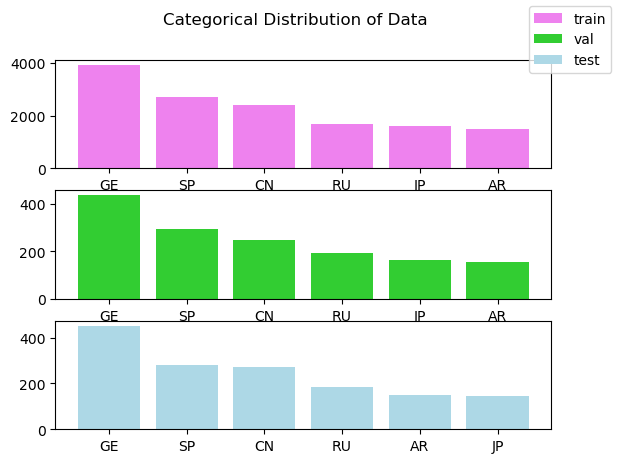

In [18]:
ds_tr, ds_vl, ds_ts = train_test_val_split(masked_dataset)

In [100]:

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base', 
                                             #additional_special_tokens = spec_tokens, #this doesn't work with vocab_size 
                                            )

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

<h2> Weighted Cross-Entropy Loss </h2>

Swap the loss function in RoBERTa: code below adapted from:
https://github.com/huggingface/transformers/issues/10845

Weighted Cross-Entropy:
https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab
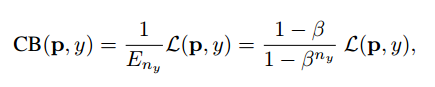
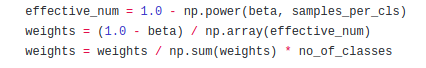

In [318]:
# Weights
beta = 0.999
samples_per_class = ds_tr['Target'].value_counts()
effective_num = 1.0 - np.power(beta, samples_per_class)
weights = (1.0 - beta) / effective_num
weights = weights / np.sum(weights)*n_classes
# these weights were too heavy
#w = ds_tr['Target'].value_counts().transform(lambda x: 1/x)*1000
# IMPORTANT: connect the weights to the target IDS
weights = torch.tensor([w[a] for a in target_idx]).to(torch.float32)
#weights = torch.tensor(weights + np.mean(weights))
#focal_loss = FocalLoss(gamma = 2.0,
#                      weights = weights,
#                      reduction = 'mean',
#                      eps = 1e-5,
#                      ignore_index = None)


In [321]:
weights

tensor([0.2551, 0.4136, 0.6238, 0.5917, 0.3720, 0.6689])

In [154]:

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                                    num_labels = n_classes,
                                                                     attention_probs_dropout_prob = 0.05,
                                                                     hidden_dropout_prob = 0.05,
                                                                    classifier_dropout = 0.0,
                                                                    id2label = idx_target,
                                                                    label2id = target_idx,
                                                                output_attentions = True,
                                                                output_hidden_states = True)


bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased', 
                                                          num_labels = n_classes,
                                                          attention_probs_dropout_prob = 0.05,
                                                          hidden_dropout_prob = 0.05,
                                                          classifier_dropout = 0.0,
                                                          id2label = idx_target,
                                                          label2id = target_idx,
                                                          output_attentions = True,
                                                          output_hidden_states = True)

bert_base = BertForMaskedLM.from_pretrained('bert-base-cased',
                                            output_attentions = True,
                                            output_hidden_states = True)

roberta_base = RobertaForMaskedLM.from_pretrained('roberta-base',
                                                  output_attentions = True,
                                                  output_hidden_states = True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
# add special tokens to model vocabulary:
bert_vocab = bert_model.get_vocab() 
roberta_vocab = roberta_model.get_vocab()

for j,k in spec_tokens:
    
bert_vocab.update({'mynewword' : len(bert_vocab)})

In [389]:
import torch.nn.functional as F

class CustomModel(nn.Module):
    
    def __init__(self, model, num_labels, loss_fn): #checkpoint, num_labels): 
        super(CustomModel,self).__init__() 
        self.num_labels = num_labels 
        #Load Model with given checkpoint and extract its body
        self.model = model# = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.00) 
        self.linear = nn.Linear(512, 1)
        self.layer_norm = nn.LayerNorm([768, 1])
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights

        self.loss_fn = loss_fn

    def forward(self, input_ids=None, token_type_ids = None, attention_mask=None,labels=None):
        #Extract outputs from the MLM model
        outputs = self.model(input_ids=input_ids, token_type_ids = token_type_ids, attention_mask=attention_mask)
        #Get Last hidden state
        sequence_output = self.dropout(outputs['hidden_states'][-1])
        # condense the 512 tokens into 1 dimension
        token_crunch = self.linear(sequence_output.transpose(-2,-1)) 
        normed = self.layer_norm(token_crunch)
        # condense the features into 6 class values 
        logits = self.classifier(normed.transpose(-2,-1)).squeeze(1)
        
        # calculate losses
        loss = None
        if labels is not None:
          #loss_fct = nn.CrossEntropyLoss(weight = class_weights)
            loss = self.loss_fn(logits, labels.long())

        return SequenceClassifierOutput(loss=loss, 
                                        logits=logits, 
                                        hidden_states=outputs.hidden_states, 
                                        attentions=outputs.attentions)

In [390]:
weighted_cross_entropy_loss = nn.CrossEntropyLoss(weight=weights)

roberta_custom_wgt_cel = CustomModel(roberta_base,
                                    num_labels = n_classes,
                                    loss_fn = weighted_cross_entropy_loss)

In [198]:

l = nn.Linear(in_features = 512, out_features = 1)
d = nn.Dropout(0.1)
c = nn.Linear(in_features = 768, out_features = 6)

In [359]:
last_hidden = o['hidden_states'][-1]
print(last_hidden.shape)

torch.Size([2, 512, 768])


In [360]:
last_hidden.transpose(-2,-1).shape

torch.Size([2, 768, 512])

In [361]:
 m = l(last_hidden.transpose(-2,-1))
m.shape

torch.Size([2, 768, 1])

In [362]:
n = d(m)
print(n.shape, n.dtype)

torch.Size([2, 768, 1]) torch.float32


In [364]:
j = c(n.transpose(-2,-1)).squeeze(1).float()
print(j.shape, j.dtype, j)

torch.Size([2, 6]) torch.float32 tensor([[ 0.1494, -0.0362,  0.0212,  0.0374,  0.0029,  0.0714],
        [ 0.1220, -0.0217,  0.0216, -0.0450,  0.1950,  0.0048]],
       grad_fn=<SqueezeBackward1>)


In [368]:
print(labels.dtype, labels.shape, labels)

torch.int64 torch.Size([2]) tensor([0, 1])


In [366]:
weights.to(torch.float32)

tensor([0.2551, 0.4136, 0.6238, 0.5917, 0.3720, 0.6689])

In [367]:
h = nn.CrossEntropyLoss(weights)
h(j, labels)#.to(torch.float32))

tensor(1.7953, grad_fn=<NllLossBackward0>)

In [289]:
j

tensor([[ 0.1212, -0.0323,  0.0100,  0.0713, -0.0189,  0.0911],
        [ 0.1390, -0.0163,  0.0406, -0.0970,  0.2217, -0.0293]],
       grad_fn=<SqueezeBackward1>)

In [296]:
weights

tensor([0.2551, 0.4136, 0.6238, 0.5917, 0.3720, 0.6689], dtype=torch.float64)

In [374]:
loss = nn.CrossEntropyLoss(weight=weights)
inpt = j.squeeze()#torch.randn(3, 6, requires_grad=True)
target = labels.long()#torch.empty(3, dtype=torch.long).random_(5)
output = loss(inpt, target)
#output.backward()
print(inpt, target, output)

tensor([[ 0.1494, -0.0362,  0.0212,  0.0374,  0.0029,  0.0714],
        [ 0.1220, -0.0217,  0.0216, -0.0450,  0.1950,  0.0048]],
       grad_fn=<SqueezeBackward0>) tensor([0, 1]) tensor(1.7953, grad_fn=<NllLossBackward0>)


In [334]:
help(nn.CrossEntropyLoss)

Help on class CrossEntropyLoss in module torch.nn.modules.loss:

class CrossEntropyLoss(_WeightedLoss)
 |  CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None, ignore_index: int = -100, reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None
 |  
 |  This criterion computes the cross entropy loss between input and target.
 |  
 |  It is useful when training a classification problem with `C` classes.
 |  If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
 |  assigning weight to each of the classes.
 |  This is particularly useful when you have an unbalanced training set.
 |  
 |  The `input` is expected to contain raw, unnormalized scores for each class.
 |  `input` has to be a Tensor of size :math:`(C)` for unbatched input,
 |  :math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
 |  `K`-dimensional case. The last being useful for higher dimension inputs, such
 |  as computing

In [377]:
roberta_custom_wgt_cel.parameters

<bound method Module.parameters of CustomModel(
  (model): RobertaForMaskedLM(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
              

In [391]:
optim = AdamW(roberta_custom_wgt_cel.parameters(), lr=lr)


In [392]:
stats_roberta_custom_2 = BERT_fine_tune_train(roberta_custom_wgt_cel,
                    train_dataloader,
                    validation_dataloader,
                    device = device,
                    metric = metric,
                    optimizer = optim,
                    scheduler = scheduler,
                    epochs = epochs,
                    lr = lr,
                    n_warmup = n_warmup
                    )


======== Epoch 1 / 1 ========
Training...
  Batch    50 / 6,907  -  Avg Batch Loss: 1.9658  -  Elapsed: 0:01:59
  Batch   100 / 6,907  -  Avg Batch Loss: 1.8570  -  Elapsed: 0:03:56
  Batch   150 / 6,907  -  Avg Batch Loss: 1.8801  -  Elapsed: 0:05:52
  Batch   200 / 6,907  -  Avg Batch Loss: 1.8998  -  Elapsed: 0:07:49
  Batch   250 / 6,907  -  Avg Batch Loss: 1.7952  -  Elapsed: 0:09:44
  Batch   300 / 6,907  -  Avg Batch Loss: 1.8556  -  Elapsed: 0:11:40
  Batch   350 / 6,907  -  Avg Batch Loss: 1.8890  -  Elapsed: 0:13:34
  Batch   400 / 6,907  -  Avg Batch Loss: 1.8623  -  Elapsed: 0:15:28
  Batch   450 / 6,907  -  Avg Batch Loss: 1.8118  -  Elapsed: 0:17:22
  Batch   500 / 6,907  -  Avg Batch Loss: 1.7937  -  Elapsed: 0:19:18
  Batch   550 / 6,907  -  Avg Batch Loss: 1.8410  -  Elapsed: 0:21:16
  Batch   600 / 6,907  -  Avg Batch Loss: 1.8522  -  Elapsed: 0:23:18
  Batch   650 / 6,907  -  Avg Batch Loss: 1.8506  -  Elapsed: 0:25:18
  Batch   700 / 6,907  -  Avg Batch Loss: 1.790

  Batch 5,900 / 6,907  -  Avg Batch Loss: 1.7577  -  Elapsed: 3:47:26
  Batch 5,950 / 6,907  -  Avg Batch Loss: 1.8380  -  Elapsed: 3:49:18
  Batch 6,000 / 6,907  -  Avg Batch Loss: 1.8041  -  Elapsed: 3:51:16
  Batch 6,050 / 6,907  -  Avg Batch Loss: 1.7747  -  Elapsed: 3:53:15
  Batch 6,100 / 6,907  -  Avg Batch Loss: 1.8216  -  Elapsed: 3:55:14
  Batch 6,150 / 6,907  -  Avg Batch Loss: 1.7852  -  Elapsed: 3:57:12
  Batch 6,200 / 6,907  -  Avg Batch Loss: 1.7772  -  Elapsed: 3:59:10
  Batch 6,250 / 6,907  -  Avg Batch Loss: 1.7649  -  Elapsed: 4:01:02
  Batch 6,300 / 6,907  -  Avg Batch Loss: 1.8223  -  Elapsed: 4:02:55
  Batch 6,350 / 6,907  -  Avg Batch Loss: 1.8206  -  Elapsed: 4:04:48
  Batch 6,400 / 6,907  -  Avg Batch Loss: 1.7965  -  Elapsed: 4:06:42
  Batch 6,450 / 6,907  -  Avg Batch Loss: 1.8076  -  Elapsed: 4:08:36
  Batch 6,500 / 6,907  -  Avg Batch Loss: 1.8294  -  Elapsed: 4:10:31
  Batch 6,550 / 6,907  -  Avg Batch Loss: 1.7680  -  Elapsed: 4:12:27
  Batch 6,600 / 6,90

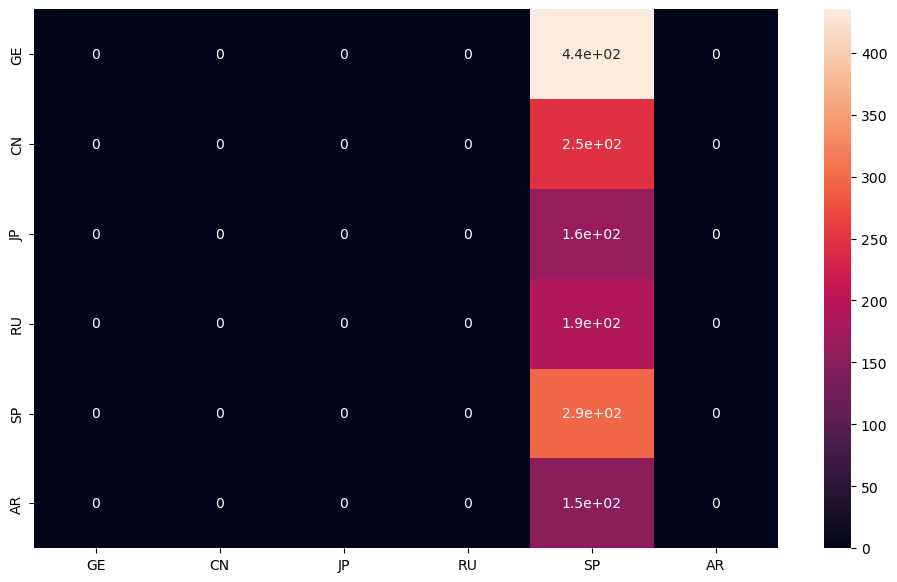

In [393]:
plot_confusion_matrix(stats_roberta_custom_2[0]['val_stats']['y_true'], 
                      stats_roberta_custom_2[0]['val_stats']['y_pred'], 
                      idx_target)

In [129]:

from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class BertClassifierCustom(nn.Module):
    '''
    Custom output layer     
    '''
    def __init__(self, model, loss_fn, classifier_head, n_classes):

        super(BertClassifierCustom, self).__init__()
        self.model = model
        self.num_labels = n_classes
        self.linear_layer = nn.Linear(in_features = 768, out_features = 768)
        self.dropout = nn.Dropout(0.10)
        self.classifier = nn.Linear(768, self.num_labels)
        self.loss_fn = loss_fn
        
    def forward(self, ids, attention_mask, token_type_ids, labels=None):
        outputs = self.model(ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        #self.classifier
        #output = self.dropout(outputs.pooler_output)
        logits = outputs.logits
        linear_layer(outputs)
        loss = None
        
        if labels is not None:
            # you can define any loss function here yourself
            # see https://pytorch.org/docs/stable/nn.html#loss-functions for an overview
            #loss_fct = focal_loss
            # next, compute the loss based on logits + ground-truth labels
        #loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
            loss = self.loss_fn(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


ImportError: cannot import name 'RobertaClassifier' from 'transformers.modeling_outputs' (/Users/paulp/miniforge3/envs/pyto/lib/python3.9/site-packages/transformers/modeling_outputs.py)

In [113]:
weighted_cel = nn.CrossEntropyLoss(weights.float())

In [115]:
roberta_cls_weighted_loss_mdl = BertClassifierCustom(roberta_model, loss_fn=weighted_cel, n_classes=n_classes)
bert_cls_weighted_loss_mdl = BertClassifierCustom(bert_model, loss_fn = weighted_cel, n_classes=n_classes)

In [116]:
max_len = 512
batch_size = 2
lr = 1e-5
n_warmup = 0
epochs = 1
#w_d = 0.0001
use_mps = torch.has_mps
#device = torch.device('mps' if use_mps else 'cpu') STILL not working
device = torch.device('cpu')


In [117]:
train_dataset = ClassificationDataset(ds_tr, roberta_tokenizer, target_idx, max_seq_len=max_len)
val_dataset = ClassificationDataset(ds_vl, roberta_tokenizer, target_idx, max_seq_len=max_len)
test_dataset = ClassificationDataset(ds_ts, roberta_tokenizer, target_idx, max_seq_len=max_len)

train_dataloader = DataLoader(
    train_dataset, 
    sampler = RandomSampler(train_dataset), 
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size = batch_size)

test_dataloader = DataLoader(
    test_dataset,
    sampler = RandomSampler(test_dataset),
    batch_size = batch_size)

In [118]:
total_steps = len(train_dataloader)*epochs

optim = AdamW(roberta_cls_weighted_loss_mdl.parameters(), lr=lr)

scheduler = get_linear_schedule_with_warmup(optim,
                                           num_warmup_steps = n_warmup,
                                           num_training_steps = total_steps)

metric = F1Score(num_classes = n_classes)

In [94]:
importlib.reload(common)
from common import BERT_fine_tune_train

In [119]:
stats_roberta = BERT_fine_tune_train(roberta_cls_weighted_loss_mdl,
                    train_dataloader,
                    validation_dataloader,
                    device = device,
                    metric = metric,
                    optimizer = optim,
                    scheduler = scheduler,
                    epochs = epochs,
                    lr = lr,
                    n_warmup = n_warmup
                    )


======== Epoch 1 / 1 ========
Training...
  Batch    50 / 6,907  -  Avg Batch Loss: 1.7652  -  Elapsed: 0:01:42
  Batch   100 / 6,907  -  Avg Batch Loss: 1.7465  -  Elapsed: 0:03:25
  Batch   150 / 6,907  -  Avg Batch Loss: 1.8245  -  Elapsed: 0:05:06
  Batch   200 / 6,907  -  Avg Batch Loss: 1.7779  -  Elapsed: 0:06:48
  Batch   250 / 6,907  -  Avg Batch Loss: 1.7550  -  Elapsed: 0:08:29
  Batch   300 / 6,907  -  Avg Batch Loss: 1.8274  -  Elapsed: 0:10:11
  Batch   350 / 6,907  -  Avg Batch Loss: 1.7829  -  Elapsed: 0:11:55
  Batch   400 / 6,907  -  Avg Batch Loss: 1.7707  -  Elapsed: 0:13:37
  Batch   450 / 6,907  -  Avg Batch Loss: 1.7904  -  Elapsed: 0:15:20
  Batch   500 / 6,907  -  Avg Batch Loss: 1.7571  -  Elapsed: 0:17:04
  Batch   550 / 6,907  -  Avg Batch Loss: 1.7895  -  Elapsed: 0:18:47
  Batch   600 / 6,907  -  Avg Batch Loss: 1.7951  -  Elapsed: 0:20:31
  Batch   650 / 6,907  -  Avg Batch Loss: 1.7641  -  Elapsed: 0:22:16
  Batch   700 / 6,907  -  Avg Batch Loss: 1.805

  Batch 5,900 / 6,907  -  Avg Batch Loss: 1.7920  -  Elapsed: 3:23:02
  Batch 5,950 / 6,907  -  Avg Batch Loss: 1.7814  -  Elapsed: 3:24:44
  Batch 6,000 / 6,907  -  Avg Batch Loss: 1.7600  -  Elapsed: 3:26:26
  Batch 6,050 / 6,907  -  Avg Batch Loss: 1.7497  -  Elapsed: 3:28:08
  Batch 6,100 / 6,907  -  Avg Batch Loss: 1.7306  -  Elapsed: 3:29:48
  Batch 6,150 / 6,907  -  Avg Batch Loss: 1.7360  -  Elapsed: 3:31:28
  Batch 6,200 / 6,907  -  Avg Batch Loss: 1.8122  -  Elapsed: 3:33:08
  Batch 6,250 / 6,907  -  Avg Batch Loss: 1.7793  -  Elapsed: 3:34:48
  Batch 6,300 / 6,907  -  Avg Batch Loss: 1.8062  -  Elapsed: 3:36:28
  Batch 6,350 / 6,907  -  Avg Batch Loss: 1.7834  -  Elapsed: 3:38:09
  Batch 6,400 / 6,907  -  Avg Batch Loss: 1.7715  -  Elapsed: 3:39:50
  Batch 6,450 / 6,907  -  Avg Batch Loss: 1.7803  -  Elapsed: 3:41:31
  Batch 6,500 / 6,907  -  Avg Batch Loss: 1.8069  -  Elapsed: 3:43:11
  Batch 6,550 / 6,907  -  Avg Batch Loss: 1.7834  -  Elapsed: 3:44:51
  Batch 6,600 / 6,90

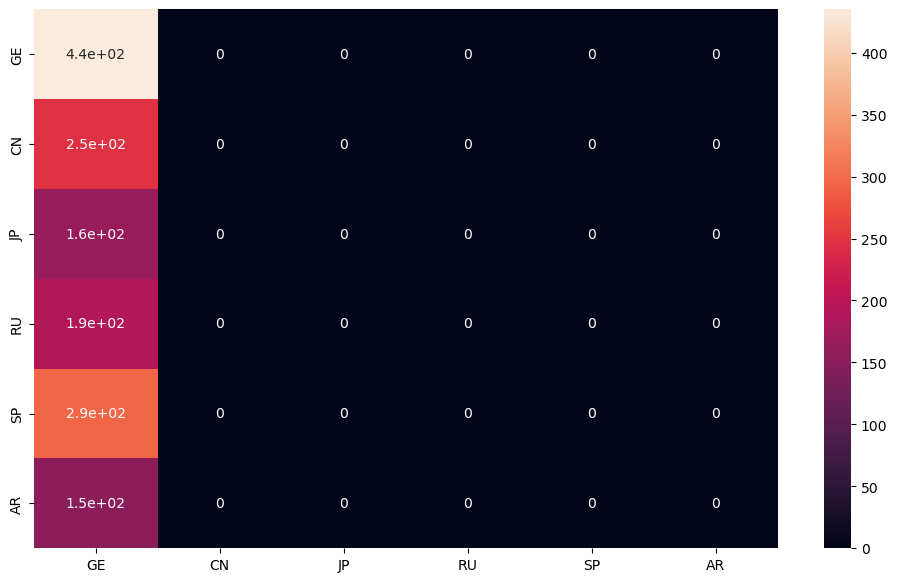

In [120]:
plot_confusion_matrix(stats_roberta[0]['val_stats']['y_true'], 
                      stats_roberta[0]['val_stats']['y_pred'], 
                      idx_target)

In [127]:
roberta_model.parameters

<bound method Module.parameters of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.15, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [43]:
stats

[{'epoch': 1,
  'val_stats': {'avg_val_loss': 1.7984882758189273,
   'val_time': '0:06:16',
   'val_f1': tensor(0.1029),
   'avg_flat_acc': 0.1028225806451613,
   'y_pred': tensor([5, 5, 5,  ..., 5, 5, 5], dtype=torch.int32),
   'y_true': tensor([3, 2, 3,  ..., 2, 3, 0], dtype=torch.int32)},
  'train_stats': {'avg_train_loss': 1.7987718363651857,
   'training_time': '6:15:42'}}]

<h2> BERT </h2>


In [101]:
train_dataset = ClassificationDataset(ds_tr, bert_tokenizer, target_idx, max_seq_len=max_len)
val_dataset = ClassificationDataset(ds_vl, bert_tokenizer, target_idx, max_seq_len=max_len)
test_dataset = ClassificationDataset(ds_ts, bert_tokenizer, target_idx, max_seq_len=max_len)

train_dataloader = DataLoader(
    train_dataset, 
    sampler = RandomSampler(train_dataset), 
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size = batch_size)

test_dataloader = DataLoader(
    test_dataset,
    sampler = RandomSampler(test_dataset),
    batch_size = batch_size)

In [102]:
optim = AdamW(bert_cls_weighted_loss_mdl.parameters(), lr=lr)

scheduler = get_linear_schedule_with_warmup(optim,
                                           num_warmup_steps = n_warmup,
                                           num_training_steps = total_steps)


In [103]:
stats_bert = BERT_fine_tune_train(bert_cls_weighted_loss_mdl,
                    train_dataloader,
                    validation_dataloader,
                    device = device,
                    metric = metric,
                    optimizer = optim,
                    scheduler = scheduler,
                    epochs = epochs,
                    lr = lr,
                    n_warmup = n_warmup
                    )


======== Epoch 1 / 1 ========
Training...
  Batch    50 / 6,907  -  Avg Batch Loss: 1.8472  -  Elapsed: 0:01:38
  Batch   100 / 6,907  -  Avg Batch Loss: 1.8631  -  Elapsed: 0:03:17
  Batch   150 / 6,907  -  Avg Batch Loss: 1.7984  -  Elapsed: 0:04:55
  Batch   200 / 6,907  -  Avg Batch Loss: 1.8306  -  Elapsed: 0:06:33
  Batch   250 / 6,907  -  Avg Batch Loss: 1.8026  -  Elapsed: 0:08:12
  Batch   300 / 6,907  -  Avg Batch Loss: 1.8317  -  Elapsed: 0:09:50
  Batch   350 / 6,907  -  Avg Batch Loss: 1.7656  -  Elapsed: 0:11:29
  Batch   400 / 6,907  -  Avg Batch Loss: 1.8420  -  Elapsed: 0:13:07
  Batch   450 / 6,907  -  Avg Batch Loss: 1.8220  -  Elapsed: 0:14:46
  Batch   500 / 6,907  -  Avg Batch Loss: 1.7931  -  Elapsed: 0:16:24
  Batch   550 / 6,907  -  Avg Batch Loss: 1.8242  -  Elapsed: 0:18:03
  Batch   600 / 6,907  -  Avg Batch Loss: 1.8442  -  Elapsed: 0:19:42
  Batch   650 / 6,907  -  Avg Batch Loss: 1.7961  -  Elapsed: 0:21:26
  Batch   700 / 6,907  -  Avg Batch Loss: 1.791

  Batch 5,900 / 6,907  -  Avg Batch Loss: 1.7957  -  Elapsed: 3:22:47
  Batch 5,950 / 6,907  -  Avg Batch Loss: 1.7860  -  Elapsed: 3:24:26
  Batch 6,000 / 6,907  -  Avg Batch Loss: 1.7630  -  Elapsed: 3:26:05
  Batch 6,050 / 6,907  -  Avg Batch Loss: 1.7927  -  Elapsed: 3:27:44
  Batch 6,100 / 6,907  -  Avg Batch Loss: 1.7905  -  Elapsed: 3:29:24
  Batch 6,150 / 6,907  -  Avg Batch Loss: 1.7974  -  Elapsed: 3:31:03
  Batch 6,200 / 6,907  -  Avg Batch Loss: 1.7777  -  Elapsed: 3:32:42
  Batch 6,250 / 6,907  -  Avg Batch Loss: 1.7812  -  Elapsed: 3:34:21
  Batch 6,300 / 6,907  -  Avg Batch Loss: 1.7998  -  Elapsed: 3:36:01
  Batch 6,350 / 6,907  -  Avg Batch Loss: 1.7455  -  Elapsed: 3:37:40
  Batch 6,400 / 6,907  -  Avg Batch Loss: 1.7718  -  Elapsed: 3:39:19
  Batch 6,450 / 6,907  -  Avg Batch Loss: 1.7243  -  Elapsed: 3:40:58
  Batch 6,500 / 6,907  -  Avg Batch Loss: 1.7932  -  Elapsed: 3:42:37
  Batch 6,550 / 6,907  -  Avg Batch Loss: 1.7774  -  Elapsed: 3:44:17
  Batch 6,600 / 6,90

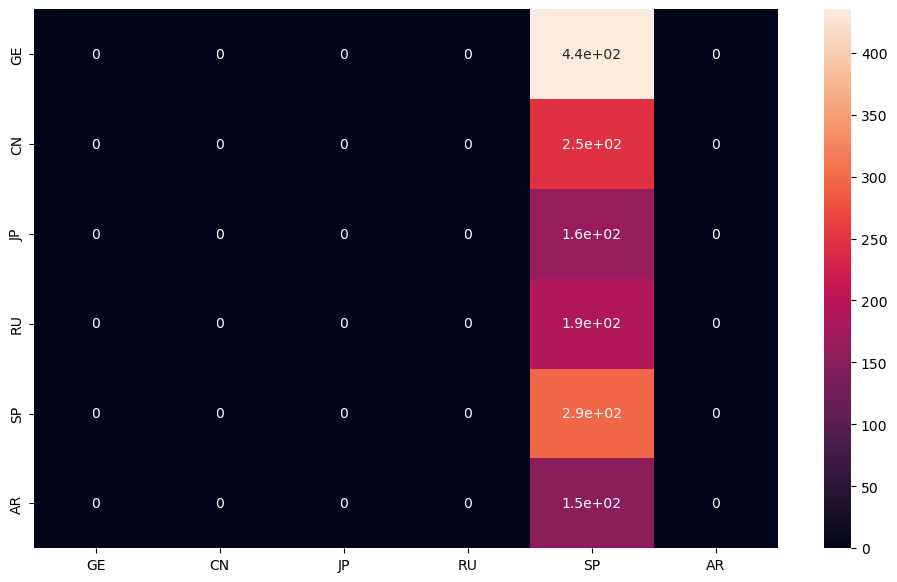

In [105]:
plot_confusion_matrix(stats_bert[0]['val_stats']['y_true'], 
                      stats_bert[0]['val_stats']['y_pred'], 
                      idx_target)

In [61]:
n = iter(validation_dataloader)

In [78]:
y_true = torch.tensor([])
y_pred = torch.tensor([])
s = next(n)
s

[{'input_ids': tensor([[[   0, 3972, 1045,  ...,    1,    1,    1]],
 
         [[   0,  100,  524,  ...,    1,    1,    1]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]]])},
 tensor([0, 1])]

In [79]:
inp_ids = s[0]['input_ids'].squeeze(1).to(device)
tok_type_ids = s[0]['token_type_ids'].squeeze(1).to(device)
attn_mask = s[0]['attention_mask'].squeeze(1).to(device)
labels = s[1].to(device)

In [172]:
roberta_model.zero_grad()
roberta_model.eval()
outs = roberta_model(inp_ids, 
                  token_type_ids = tok_type_ids, 
                  attention_mask = attn_mask, 
                  labels = labels.long(),
                    output_attentions = True,
                    output_hidden_states = True)

In [181]:
type(outs)

transformers.modeling_outputs.SequenceClassifierOutput

In [180]:
outs.last_hidden_state()

AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

In [178]:
# these should NOT be identical predictions 
outs['hidden_states'][-1].shape

torch.Size([2, 512, 768])

In [142]:
#x, y = abs(torch.randn(6)), abs(torch.randn(6))
roberta_cls_weighted_loss_mdl.zero_grad()
roberta_cls_weighted_loss_mdl.eval()
outs = roberta_cls_weighted_loss_mdl(inp_ids, 
                  token_type_ids = tok_type_ids, 
                  attention_mask = attn_mask, 
                  labels = labels.long())

In [131]:
outs

SequenceClassifierOutput(loss=tensor(1.6377, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2797,  0.0835, -0.1836, -0.1519,  0.1662, -0.2958],
        [ 0.2797,  0.0835, -0.1836, -0.1519,  0.1662, -0.2958]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [255]:
torch.onehot(labels, 6)

AttributeError: module 'torch' has no attribute 'onehot'

In [249]:

unweighted_cel = nn.CrossEntropyLoss()

In [250]:
unweighted_cel(outs.logits, labels)

tensor(1.8289, grad_fn=<NllLossBackward0>)

In [184]:
o = roberta_base(inp_ids, 
                  token_type_ids = tok_type_ids, 
                  attention_mask = attn_mask)
                  #labels = labels.long())

In [187]:
o.hidden_states[-1]

tensor([[[-0.0646,  0.0769, -0.0031,  ..., -0.0776, -0.0158, -0.0197],
         [-0.0927, -0.0502,  0.0556,  ..., -0.0848,  0.0648,  0.0055],
         [ 0.0831,  0.0728,  0.2277,  ..., -0.1048,  0.2363,  0.0517],
         ...,
         [-0.0154,  0.0519,  0.0381,  ..., -0.0384,  0.0453, -0.0053],
         [ 0.0042,  0.0628,  0.0564,  ..., -0.0166,  0.0023, -0.0335],
         [ 0.0391,  0.0482,  0.1157,  ..., -0.0126, -0.0041,  0.0547]],

        [[-0.0662,  0.1161, -0.0198,  ..., -0.0506, -0.0339, -0.0117],
         [-0.0704,  0.1625, -0.1756,  ...,  0.3305, -0.1445, -0.0913],
         [ 0.1114,  0.0472,  0.0439,  ...,  0.1169, -0.0096, -0.0491],
         ...,
         [ 0.0590, -0.0644,  0.2094,  ...,  0.1910,  0.2377,  0.0746],
         [ 0.0232,  0.0388,  0.0793,  ..., -0.0198,  0.0910,  0.1213],
         [-0.0554,  0.0802, -0.0276,  ..., -0.0137, -0.0245,  0.0167]]],
       grad_fn=<NativeLayerNormBackward0>)

tensor([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]])

In [145]:
roberta_model.parameters

<bound method Module.parameters of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.15, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [146]:
roberta_cls_weighted_loss_mdl.parameters

<bound method Module.parameters of BertClassifierCustom(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.15, inplace=False)
              )
              (output): RobertaS

In [147]:
roberta_base.parameters

<bound method Module.parameters of RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)


In [149]:
bert_model.parameters

<bound method Module.parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.15, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [152]:
from transformers import BertForMaskedLM
bert_base = BertForMaskedLM.from_pretrained('bert-base-cased')
bert_base.parameters

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<bound method Module.parameters of BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

In [148]:
class CustomModel(nn.Module):
    def __init__(self, model, num_labels): #checkpoint, num_labels): 
        super(CustomModel,self).__init__() 
        self.num_labels = num_labels 

        #Load Model with given checkpoint and extract its body
        self.model = model# = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.1) 
        self.classifier = nn.Linear(768,num_labels) # load and initialize weights

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        #Add custom layers
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

        logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

ValueError: Expected input batch_size (1024) to match target batch_size (2).

In [734]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs.squeeze(),  targets.float())
        loss = self.alpha * (1 - torch.exp(-ce_loss)) ** self.gamma * ce_loss
        return loss

In [738]:
focal_loss = FocalLoss(alpha=weights, gamma=2)
focal_loss(outs.logits, labels.long())

RuntimeError: expected scalar type Long but found Float

In [685]:
#labels = torch.zeros((batch_size, n_classes))
#focal_loss(outs.logits, labels)

In [694]:

F.one_hot(labels.long(), num_classes=n_classes)

tensor([[[1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0]]])

In [695]:
labels

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [503]:
logits = outs.logits.detach().cpu()
label_ids = labels.to('cpu').numpy()
pred = logits.argmax(dim=1).unsqueeze(0)
y_pred = torch.cat((y_pred, pred), -1)
#label_ids = label_ids.cat(b_labels.to('cpu').numpy())
y_true = torch.cat((y_true, labels.detach().cpu()), -1)
#label_ids = torch.cat(label_ids, b_labels)
